# Import libraries>>>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import eli5 as eli5

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from eli5.sklearn import PermutationImportance
from fancyimpute import KNN
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [8]:
pd.options.display.large_repr

'truncate'

# Meet and Greet Data>>>

In [2]:
train_raw = pd.read_csv('train-1541136939101.csv',sep = ',',na_values=['',' ','NA'])
train_labels = pd.read_csv('trainlabels-1541136939101.csv',sep = ',', na_values = ['',' ','NA'])
test = pd.read_csv('test-1541136939101.csv',sep = ',', na_values = ['',' ','NA'])

# Observing the data>>>

In [4]:
train_raw.head(20)
train_raw.dtypes
train_labels.head(20)
train_labels.columns = ['Id','Status']; train_labels.columns
train = pd.merge(train_raw,train_labels)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44068 entries, 0 to 44067
Data columns (total 35 columns):
Id                       44068 non-null int64
Amount_of_water          44068 non-null float64
Gps_height               44068 non-null int64
Waterpointname           44068 non-null object
Waterpoint_type          44068 non-null object
Basin_name               44068 non-null object
Village                  44068 non-null object
Regionname               44068 non-null object
Region_code              44068 non-null int64
Wardname                 44068 non-null object
District_code            44068 non-null int64
Population               44068 non-null int64
Public_meeting           41543 non-null object
Organization_funding     41468 non-null object
Organization_surveyed    44068 non-null object
Scheme_management        41138 non-null object
SchemeName               23117 non-null object
Permit                   41841 non-null object
Company_installed        41465 non-null object
Ma

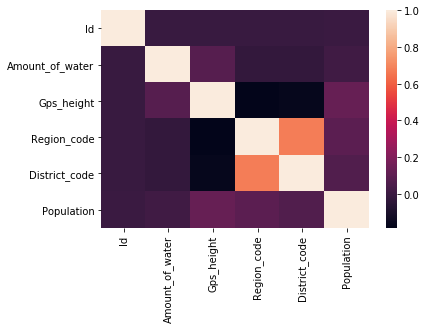

In [5]:
corrma = train.corr()
sns.heatmap(corrma)

# Target Split>>>

In [5]:
total = [train,test]
target = train['Status']

In [6]:
train.drop('Status',axis = 1, inplace=True)

# Profiling>>>

In [9]:
pp.ProfileReport(train)

Number of variables,35
Number of observations,44068
Total Missing (%),2.2%
Total size in memory,12.1 MiB
Average record size in memory,288.0 B
Numeric,6
Categorical,28
Boolean,0
Date,0
Text (Unique),0
Rejected,1


In [8]:
pp.ProfileReport(test)

Number of variables,34
Number of observations,11015
Total Missing (%),1.9%
Total size in memory,2.9 MiB
Average record size in memory,272.0 B
Numeric,6
Categorical,27
Boolean,0
Date,0
Text (Unique),0
Rejected,1


# Dealing with NA's>>>

In [9]:
for data in total:
    data.drop(['Village','Id', 'Organization_surveyed','Regionname','Scheme_management',
               'Management_group','Extraction_type_group','Extraction_type_class','Payment',
               'Quality_group','Source_type','Waterpoint_type_group','Waterpointname','Quantity_group','Wardname'], inplace = True, axis = 1)

In [10]:
print(train.isnull().sum())
print(test.isnull().sum())

Amount_of_water             0
Gps_height                  0
Waterpoint_type             0
Basin_name                  0
Region_code                 0
District_code               0
Population                  0
Public_meeting           2525
Organization_funding     2600
SchemeName              20951
Permit                   2227
Company_installed        2603
Management                  0
Extraction_type             0
Payment_type                0
Water_quality               0
Quantity                    0
Source                      0
Source_class                0
dtype: int64
Amount_of_water            0
Gps_height                 0
Waterpoint_type            0
Basin_name                 0
Region_code                0
District_code              0
Population                 0
Public_meeting           653
Organization_funding       0
SchemeName              5211
Permit                   529
Company_installed          0
Management                 0
Extraction_type            0
Payment_typ

In [11]:
for data in total:
    data['Public_meeting'].fillna('Unknown',inplace=True,axis=0)

In [12]:
for data in total:
    data['SchemeName'].fillna('Noscheme',inplace = True, axis = 0)

In [13]:
for data in total:
    data['Organization_funding'].fillna('Unknown',inplace = True, axis =0)

In [14]:
for data in total:
    data['Permit'].fillna('Unknown',inplace = True, axis =0)

In [15]:
for data in total:
    data['Company_installed'].fillna('random',inplace = True, axis =0)

# Checking Data types>>>

In [16]:
for data in total:
    data['Gps_height'] = pd.qcut(data['Gps_height'],4,labels=[1,2,3,4])

In [17]:
for data in total:
    data['Population'] = pd.cut(data['Population'],4,labels=[1,2,3,4])

In [18]:
for data in total:
    data['Amount_of_water'] = pd.cut(data['Amount_of_water'],4,labels=[1,2,3,4])

In [19]:
for data in total:
    data['District_code'] = data['District_code'].astype('category')

In [20]:
def transform_feature(df, column_name):
    unique_values = set(df[column_name].tolist())
    transformer_dict = {}
    for index, value in enumerate(unique_values):
        transformer_dict[value] = index
    df[column_name] = df[column_name].apply(lambda y: transformer_dict[y])
    return df

In [21]:
integer_columns = ['Population', 'District_code','Amount_of_water','Gps_height'] 
columns_to_transform = [col for col in train.columns if col not in integer_columns]
for column in columns_to_transform: 
    train = transform_feature(train, column)
    test = transform_feature(test, column)

# Model Building>>>

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train,target,
                                                    test_size = 0.02,random_state = 100)

## 1> Random Forest Classifier

In [23]:
rfc = RandomForestClassifier(n_estimators=1000,min_samples_split=6,
                                              criterion='gini', 
                                              max_features='auto',
                                              oob_score=True,
                                              random_state=1,
                                              n_jobs=-1)
gr = rfc.fit(X_train,y_train)
print('Random Forest Classifier Train Score:',rfc.score(X_train,y_train))
print('Random Forest Classifier Test Score:',rfc.score(X_test,y_test))

Random Forest Classifier Train Score: 0.9536192284536655
Random Forest Classifier Test Score: 0.8741496598639455


In [25]:
perm = PermutationImportance(gr, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_train.columns.tolist())

Weight,Feature
0.1107 ± 0.0254,Quantity
0.1054 ± 0.0110,Organization_funding
0.0220 ± 0.0068,Company_installed
0.0159 ± 0.0064,Waterpoint_type
0.0113 ± 0.0102,Payment_type
0.0063 ± 0.0031,District_code
0.0036 ± 0.0065,Basin_name
0.0032 ± 0.0033,Region_code
0.0029 ± 0.0068,Extraction_type
0.0027 ± 0.0031,SchemeName


In [ ]:
preds = rfc.predict(test)
ids = pd.read_csv('test-1541136939101.csv')
submission = pd.DataFrame()
submission['Id'] = ids.Id
submission['Status'] = preds
submission.set_index('Id',inplace=True)
submission.to_csv('Subsrfc.csv')

## 2> Decision Tree

In [26]:
dtc = DecisionTreeClassifier()
dt = dtc.fit(X_train,y_train)
print('Decision Tree Classifier Train Score:',dtc.score(X_train,y_train))
print('Decision Tree Classifier Test Score:',dtc.score(X_test,y_test))

Decision Tree Classifier Train Score: 0.9608901032742092
Decision Tree Classifier Test Score: 0.8662131519274376


In [27]:
perm = PermutationImportance(dt, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm,feature_names = X_train.columns.tolist())

Weight,Feature
0.2365 ± 0.0074,Organization_funding
0.1726 ± 0.0161,Company_installed
0.1263 ± 0.0197,Quantity
0.0347 ± 0.0053,District_code
0.0317 ± 0.0146,Region_code
0.0297 ± 0.0149,Payment_type
0.0295 ± 0.0138,Waterpoint_type
0.0252 ± 0.0102,Extraction_type
0.0227 ± 0.0113,Source
0.0172 ± 0.0133,Gps_height


In [ ]:
preds = dtc.predict(test)
submission = pd.DataFrame()
submission['Id'] = ids.Id
submission['Status'] = preds
submission.set_index('Id',inplace=True)
submission.to_csv('Subsdtc.csv')

## 3> Gradient Boosting

In [28]:
gbc = GradientBoostingClassifier()
gb = gbc.fit(X_train,y_train)
print('Gradient Boost Classifier Train Score:',gbc.score(X_train,y_train))
print('Gradient Boost Classifier Test Score:',gbc.score(X_test,y_test))

Gradient Boost Classifier Train Score: 0.847682119205298
Gradient Boost Classifier Test Score: 0.8276643990929705


In [29]:
perm = PermutationImportance(gb, random_state=1,).fit(X_test, y_test)
eli5.show_weights(perm,feature_names = X_train.columns.tolist())

Weight,Feature
0.1134 ± 0.0338,Quantity
0.1109 ± 0.0157,Organization_funding
0.0481 ± 0.0171,Company_installed
0.0317 ± 0.0090,Waterpoint_type
0.0141 ± 0.0023,Payment_type
0.0073 ± 0.0096,Extraction_type
0.0073 ± 0.0062,Region_code
0.0050 ± 0.0051,Gps_height
0.0050 ± 0.0031,Public_meeting
0.0039 ± 0.0031,District_code


In [ ]:
preds = gbc.predict(test)
submission = pd.DataFrame()
submission['Id'] = ids.Id
submission['Status'] = preds
submission.set_index('Id',inplace=True)
submission.to_csv('Subsgb.csv')

## 4> XgBoost

In [30]:
xgb = XGBClassifier()
xg = xgb.fit(X_train,y_train)
print('XGBoost Classifier Train Score:',xgb.score(X_train,y_train))
print('XGBoost Classifier Test Score:',xgb.score(X_test,y_test))

ValueError: DataFrame.dtypes for data must be int, float or bool.
                Did not expect the data types in fields Amount_of_water, Gps_height, District_code, Population

In [ ]:
perm = PermutationImportance(xg, random_state=1,).fit(X_test, y_test)
eli5.show_weights(perm,feature_names = X_train.columns.tolist())

In [ ]:
preds = xgb.predict(test)
submission = pd.DataFrame()
submission['Id'] = ids.Id
submission['Status'] = preds
submission.set_index('Id',inplace=True)
submission.to_csv('Subsxgb.csv')

## 5> Naive Bayes

In [31]:
nbc = GaussianNB()
nb = nbc.fit(X_train,y_train)
print('Naive Bayes Classifier Train Score:',nbc.score(X_train,y_train))
print('Naive Bayes Classifier Test Score:',nbc.score(X_test,y_test))

Naive Bayes Classifier Train Score: 0.7145371185106284
Naive Bayes Classifier Test Score: 0.7063492063492064


In [32]:
perm = PermutationImportance(nb, random_state=1,).fit(X_test, y_test)
eli5.show_weights(perm,feature_names = X_train.columns.tolist())

Weight,Feature
0.0868 ± 0.0156,Quantity
0.0494 ± 0.0124,Waterpoint_type
0.0190 ± 0.0174,Organization_funding
0.0150 ± 0.0128,District_code
0.0100 ± 0.0146,Public_meeting
0.0073 ± 0.0098,Management
0.0068 ± 0.0094,Extraction_type
0.0054 ± 0.0072,Source
0.0052 ± 0.0082,Region_code
0.0045 ± 0.0025,Basin_name


In [ ]:
preds = nbc.predict(test)
submission = pd.DataFrame()
submission['Id'] = ids.Id
submission['Status'] = preds
submission.set_index('Id',inplace=True)
submission.to_csv('Subsnb.csv')